In [1]:

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plot
%matplotlib inline
import seaborn as sns
import sklearn
import pandas
from flask import Flask
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score

In [3]:
dataset=pd.read_csv("/content/flightdata.csv")
dataset.head()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [5]:
dataset = dataset.drop('Unnamed: 25', axis=1)
dataset.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [6]:
#filter the dataset to clininate columns that aren't relevant to a predictive model.
dataset = dataset[["FL_NUM", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME", "DEP_DELAY","DEP_DEL15", "ARR_DELAY","ARR_DEL15"]]
dataset.isnull().sum()                  

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_ARR_TIME      0
DEP_DELAY       107
DEP_DEL15       107
ARR_DELAY       188
ARR_DEL15       188
dtype: int64

In [7]:
dataset[dataset.isnull().any(axis=1)].head(10)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,-2.0,0.0,NaN,NaN
179,86,1,10,7,MSP,DTW,1632,NaN,NaN,NaN,NaN
184,557,1,10,7,MSP,DTW,912,-5.0,0.0,NaN,NaN
210,1096,1,10,7,DTW,MSP,1303,NaN,NaN,NaN,NaN
478,1542,1,22,5,SEA,JFK,723,NaN,NaN,NaN,NaN
481,1795,1,22,5,ATL,JFK,2014,NaN,NaN,NaN,NaN
491,2312,1,22,5,MSP,JFK,2149,NaN,NaN,NaN,NaN
499,423,1,23,6,JFK,ATL,1600,NaN,NaN,NaN,NaN
500,425,1,23,6,JFK,ATL,1827,NaN,NaN,NaN,NaN
501,427,1,23,6,JFK,SEA,1053,NaN,NaN,NaN,NaN


In [8]:
dataset['DEP_DEL15'].mode()

0    0.0
Name: DEP_DEL15, dtype: float64

In [9]:
dataset=dataset.fillna({'ARR_DEL15': 1})
dataset=dataset.fillna({'DEP_DEL15': 0})
dataset=dataset.fillna({'ARR_DELAY': 1})
dataset=dataset.fillna({'DEP_DELAY': 0})
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,-2.0,0.0,1.0,1.0
178,2839,1,9,6,DTW,JFK,1724,-4.0,0.0,-15.0,0.0
179,86,1,10,7,MSP,DTW,1632,0.0,0.0,1.0,1.0
180,87,1,10,7,DTW,MSP,1649,24.0,1.0,14.0,0.0
181,423,1,10,7,JFK,ATL,1600,11.0,0.0,7.0,0.0
182,440,1,10,7,JFK,ATL,849,-1.0,0.0,-14.0,0.0
183,485,1,10,7,JFK,SEA,1945,65.0,1.0,10.0,0.0
184,557,1,10,7,MSP,DTW,912,-5.0,0.0,1.0,1.0


In [10]:
import math

for index, row in dataset.iterrows():
    dataset.loc[index, 'CRS_ARR_TIME'] = math.floor(row['CRS_ARR_TIME'] / 100)
dataset.head() 
                                              

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15
0,1399,1,1,5,ATL,SEA,21,2.0,0.0,-41.0,0.0
1,1476,1,1,5,DTW,MSP,14,-1.0,0.0,4.0,0.0
2,1597,1,1,5,ATL,SEA,12,2.0,0.0,-33.0,0.0
3,1768,1,1,5,SEA,MSP,13,1.0,0.0,10.0,0.0
4,1823,1,1,5,SEA,DTW,6,-4.0,0.0,8.0,0.0


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['DEST'] = le.fit_transform(dataset['DEST'])
dataset['ORIGIN'] = le.fit_transform(dataset['ORIGIN'])

In [12]:
dataset.head(5)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15
0,1399,1,1,5,0,4,21,2.0,0.0,-41.0,0.0
1,1476,1,1,5,1,3,14,-1.0,0.0,4.0,0.0
2,1597,1,1,5,0,4,12,2.0,0.0,-33.0,0.0
3,1768,1,1,5,4,3,13,1.0,0.0,10.0,0.0
4,1823,1,1,5,4,1,6,-4.0,0.0,8.0,0.0


In [13]:
dataset['ORIGIN'].unique()

array([0, 1, 4, 3, 2])

In [14]:
dataset = pd.get_dummies(dataset, columns=['ORIGIN', 'DEST'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
0,1399,1,1,5,21,2.0,0.0,-41.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,14,-1.0,0.0,4.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,12,2.0,0.0,-33.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,13,1.0,0.0,10.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,6,-4.0,0.0,8.0,0.0,0,0,0,0,1,0,1,0,0,0


In [15]:
x = dataset.iloc[:, 0:8].values
y = dataset.iloc[:, 8:9].values

In [16]:
x

array([[ 1.399e+03,  1.000e+00,  1.000e+00, ...,  2.000e+00,  0.000e+00,
        -4.100e+01],
       [ 1.476e+03,  1.000e+00,  1.000e+00, ..., -1.000e+00,  0.000e+00,
         4.000e+00],
       [ 1.597e+03,  1.000e+00,  1.000e+00, ...,  2.000e+00,  0.000e+00,
        -3.300e+01],
       ...,
       [ 1.823e+03,  1.200e+01,  3.000e+01, ...,  0.000e+00,  0.000e+00,
        -1.600e+01],
       [ 1.901e+03,  1.200e+01,  3.000e+01, ..., -1.000e+00,  0.000e+00,
        -5.000e+00],
       [ 2.005e+03,  1.200e+01,  3.000e+01, ..., -2.000e+00,  0.000e+00,
        -1.200e+01]])

In [17]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
z=oh.fit_transform(x[:,4:5]).toarray()
t=oh.fit_transform(x[:,5:6]).toarray()

In [18]:
z

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
x=np.delete(x,[4,5],axis=1)

In [21]:
dataset.describe()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
count,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000
mean,1334.325617,6.628973,15.790758,3.960199,15.067314,8.379663,0.141483,-2.513311,0.139168,0.276022,0.195975,0.122340,0.225982,0.179681,0.286795,0.196866,0.116820,0.221975,0.177544
std,811.875227,3.354678,8.782056,1.995257,5.023534,36.596640,0.348535,38.905443,0.346138,0.447048,0.396967,0.327693,0.418246,0.383939,0.452285,0.397648,0.321219,0.415593,0.382146
min,7.000000,1.000000,1.000000,1.000000,0.000000,-16.000000,0.000000,-67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,624.000000,4.000000,8.000000,2.000000,11.000000,-3.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1267.000000,7.000000,16.000000,4.000000,15.000000,-1.000000,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2032.000000,9.000000,23.000000,6.000000,19.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2853.000000,12.000000,31.000000,7.000000,23.000000,645.000000,1.000000,615.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<ipython-input-22-43f5c122a6ef>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.MONTH)


<Axes: xlabel='MONTH', ylabel='Density'>

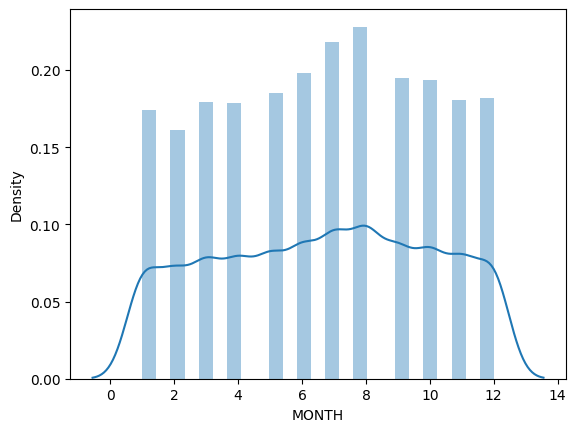

In [22]:
sns.distplot(dataset.MONTH)

<Axes: xlabel='ARR_DELAY', ylabel='ARR_DEL15'>

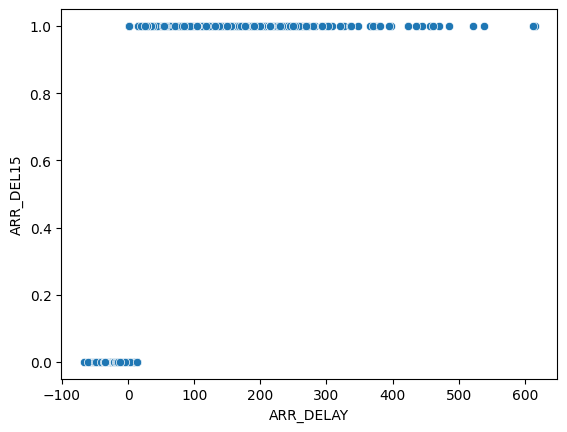

In [23]:

sns.scatterplot(x='ARR_DELAY',y='ARR_DEL15',data=dataset)

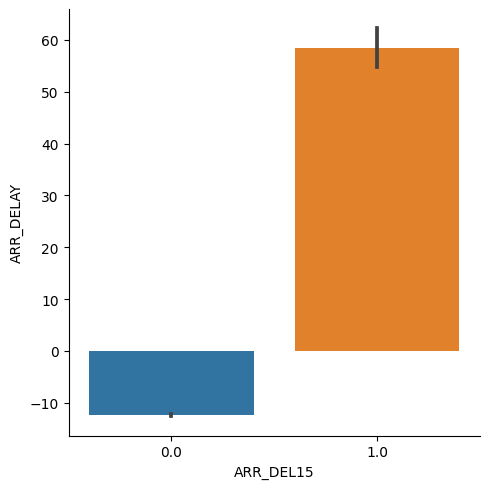

In [24]:
sns.catplot(x="ARR_DEL15",y="ARR_DELAY",kind='bar',data=dataset)

<Axes: >

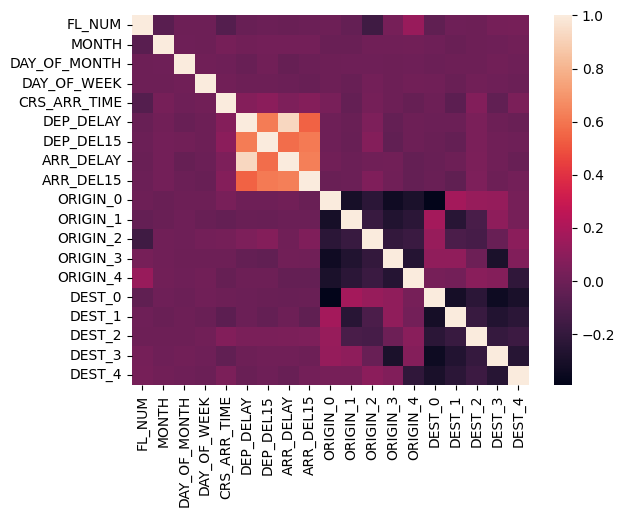

In [25]:
sns.heatmap(dataset.corr())

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test,=train_test_split (x,y,test_size=0.2,random_state=0)

In [27]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(dataset.drop('ARR_DEL15', axis=1), dataset['ARR_DEL15'], test_size=0.2, random_state=0)

In [28]:
x_test.shape

(2247, 6)

In [29]:
x_train.shape

(8984, 6)

In [30]:
y_test.shape

(2247, 1)

In [31]:
y_train.shape

(8984, 1)

In [32]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [33]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

In [34]:
decisiontree = classifier.predict(x_test)

In [35]:
decisiontree

array([1., 0., 0., ..., 0., 0., 1.])

In [36]:
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy')

In [38]:
rfc.fit(x_train,y_train)

<ipython-input-38-b87bb2ba9825>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10)

In [39]:
y_predict = rfc.predict(x_test)

In [40]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [41]:
classification =Sequential()
classification.add(Dense(30,activation='relu'))
classification.add(Dense(128,activation='relu'))
classification.add(Dense(64,activation='relu'))
classification.add(Dense(32,activation='relu'))
classification.add(Dense(1,activation='sigmoid'))


In [42]:
classification.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [43]:

classification.fit(x_train,y_train,batch_size=4,validation_split=0.2,epochs=100)

Epoch 1/100
1797/1797 [==============================] - 7s 3ms/step - loss: 0.1310 - accuracy: 0.9523 - val_loss: 0.0907 - val_accuracy: 0.9711
Epoch 2/100
1797/1797 [==============================] - 4s 2ms/step - loss: 0.0892 - accuracy: 0.9676 - val_loss: 0.0862 - val_accuracy: 0.9750
Epoch 3/100
1797/1797 [==============================] - 4s 2ms/step - loss: 0.0795 - accuracy: 0.9731 - val_loss: 0.0797 - val_accuracy: 0.9772
Epoch 4/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.0757 - accuracy: 0.9727 - val_loss: 0.0757 - val_accuracy: 0.9794
Epoch 5/100
1797/1797 [==============================] - 4s 2ms/step - loss: 0.0696 - accuracy: 0.9763 - val_loss: 0.0886 - val_accuracy: 0.9699
Epoch 6/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.0635 - accuracy: 0.9797 - val_loss: 0.0903 - val_accuracy: 0.9727
Epoch 7/100
1797/1797 [==============================] - 4s 2ms/step - loss: 0.0579 - accuracy: 0.9814 - val_loss: 0.0742 - val_ac

In [44]:
y_pred = classifier.predict([[129,99,1,0,0,0]])
print(y_pred)
(y_pred)

[0.]


array([0.])

In [46]:
y_pred=rfc.predict([[129,99,1,0,0,0]])
print(y_pred)
(y_pred)

[0.]


array([0.])

In [47]:
classification.save('flight.h5')

In [48]:
y_pred=classification.predict(x_test)

71/71 [==============================] - 0s 1ms/step


In [49]:
y_pred

array([[1.0000000e+00],
       [0.0000000e+00],
       [5.7166707e-35],
       ...,
       [2.2774410e-28],
       [0.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [50]:
y_pred=(y_pred>0.5)
y_pred

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [51]:
def predict_exit(sample_value):
    sample_value = np.array(sample_value)
    sample_value = sample_value.reshape(1, -1)
    sample_value = sc.transform(sample_value)
    return classifier.predict(sample_value)


In [52]:
test = classification.predict([[1, 1, 121.000000, 36.0, 0, 0, ]])
if test==1: 
    print('Prediction: Chance of delay')
else:
    print('Prediction: No chance of delay') 

1/1 [==============================] - 0s 36ms/step
Prediction: No chance of delay


In [53]:
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

In [54]:
    dfs = []
models = [
          ('RF',RandomForestClassifier()),
          ('DecisionTree',DecisionTreeClassifier()),
          ('ANN',MLPClassifier())
       ]
results = []
    names = []
    scoring=['accuracy','precision_weighted','recall_weighted','f1_weighted','roc_auc']
    target_names=['no delay','delay']
    for name,model in models:
        kfold=model_selection.KFold(n_splits=5,shuffle=True,random_state=90210)
        cv_results=model_selection.cross_validate(model,x_train,y_train,cv=kfold,scoring=scoring)
        clf=model.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        print(name)
        print(classification_report(y_test,y_pred,target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df=pd.DataFrame(cv_results)
        this_df['model']=name
        dfs.append(this_df)
final=pd.concat(dfs,ignore_index=True)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 

RF
              precision    recall  f1-score   support

    no delay       0.96      1.00      0.98      1936
       delay       0.99      0.77      0.86       311

    accuracy                           0.97      2247
   macro avg       0.98      0.88      0.92      2247
weighted avg       0.97      0.97      0.96      2247

DecisionTree
              precision    recall  f1-score   support

    no delay       0.96      1.00      0.98      1936
       delay       0.98      0.77      0.86       311

    accuracy                           0.96      2247
   macro avg       0.97      0.88      0.92      2247
weighted avg       0.97      0.96      0.96      2247



/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

ANN
              precision    recall  f1-score   support

    no delay       0.97      1.00      0.98      1936
       delay       0.97      0.80      0.88       311

    accuracy                           0.97      2247
   macro avg       0.97      0.90      0.93      2247
weighted avg       0.97      0.97      0.97      2247



/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [55]:
y_predict_train=model.predict(x_train)
print('Training accuracy:',accuracy_score(y_train,y_predict_train))
print('Testing accuracy:',accuracy_score(y_test,y_predict))

Training accuracy: 0.9848619768477292
Testing accuracy: 0.9666221628838452


In [56]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_predict)
cm

array([[1934,    2],
       [  73,  238]])

In [57]:
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test, decisiontree)

In [58]:
desacc

0.9643969737427681

In [59]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,decisiontree)

In [60]:
cm

array([[1929,    7],
       [  73,  238]])

In [61]:
from sklearn.metrics import accuracy_score,classification_report
score=accuracy_score(y_pred,y_test)
print('The accuracy for ANN model is:{}%'.format(score*100))

The accuracy for ANN model is:96.92923898531375%


In [62]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
cm

array([[1928,    8],
       [  61,  250]])

In [63]:
parameters={
            'n_estimators':[1,20,30,55,68,74,90,120,115],
            'criterion':['gini','entropy'],
            'max_features':["auto","sqrt","log2"],
      'max_depth':[2,5,8,10],'verbose':[1,2,3,4,6,8,9,10]

}


In [64]:
RCV = RandomizedSearchCV(estimator=rfc, param_distributions=parameters, cv=10, n_iter=4)


In [65]:
RCV.fit(x_train,y_train)


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fi

building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
buildi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]:

building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]:

building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]:

building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when


building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82 of 120
building tree 8

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep t

building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building t

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
buildin

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tree 72 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tree 72 of 90
building tree 73 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 o

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [66]:
bt_params=RCV.best_params_
bt_score=RCV.best_score_


In [67]:
bt_params


{'verbose': 2,
 'n_estimators': 30,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'entropy'}

In [68]:
bt_score


0.9910944107657358

In [69]:
model=RandomForestClassifier(verbose=10,n_estimators=120,max_features='log2',max_depth=10,criterion='entropy')
RCV.fit(x_train,y_train)


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | 

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building t

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tree 68 of 68
building tree 1 of 68
building tree 2 of 68
building tree

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tree 68 of 68


[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tr

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree 51 of 68
building tree 52 of 68
building tree 53 of 68
building tree 54 of 68
building tree 55 of 68
building tree 56 of 68
building tree 57 of 68
building tree 58 of 68
building tree 59 of 68
building tree 60 of 68
building tree 61 of 68
building tree 62 of 68
building tree 63 of 68
building tree 64 of 68
building tree 65 of 68
building tree 66 of 68
building tree 67 of 68
building tree 68 of 68


[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 68
building tree 2 of 68
building tree 3 of 68
building tree 4 of 68
building tree 5 of 68
building tree 6 of 68
building tree 7 of 68
building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 8 of 68
building tree 9 of 68
building tree 10 of 68
building tree 11 of 68
building tree 12 of 68
building tree 13 of 68
building tree 14 of 68
building tree 15 of 68
building tree 16 of 68
building tree 17 of 68
building tree 18 of 68
building tree 19 of 68
building tree 20 of 68
building tree 21 of 68
building tree 22 of 68
building tree 23 of 68
building tree 24 of 68
building tree 25 of 68
building tree 26 of 68
building tree 27 of 68
building tree 28 of 68
building tree 29 of 68
building tree 30 of 68
building tree 31 of 68
building tree 32 of 68
building tree 33 of 68
building tree 34 of 68
building tree 35 of 68
building tree 36 of 68
building tree 37 of 68
building tree 38 of 68
building tree 39 of 68
building tree 40 of 68
building tree 41 of 68
building tree 42 of 68
building tree 43 of 68
building tree 44 of 68
building tree 45 of 68
building tree 46 of 68
building tree 47 of 68
building tree 48 of 68
building tree 49 of 68
building tree 50 of 68
building tree

[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tre

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example 

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [70]:
y_predict_rfc=RCV.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


In [71]:
RFC=accuracy_score(y_test,y_predict_rfc)
RFC


0.9661771250556297

In [72]:
import pickle
pickle.dump(RCV,open('flight.pkl','wb'))
